# Projeto Final - PPGTI3102 - Tópicos Especiais em Inteligência Computacional 3

Aluno: André Victor Ribeiro de Carvalho

---

Para esse projeto foi considerado a base de dados em Português do Brasil de reviews disponíveis no IMDB.

Esse site contém uma ampla variedade de catálogos de filmes em que as pessoas cadastradas podem realizar comentários com suas opiniões.

Essa base de dados está disponível em:
* https://huggingface.co/datasets/celsowm/imdb-reviews-pt-br

## Fazendo Importações Necessárias

Para execução do código presente nesse Notebook, será necessário a realização dos imports a seguir.

Essa linha deve sempre ser executada primeiro.

In [1]:
!pip install snorkel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import os

os.environ['TOKENIZERS_PARALLELISM'] = "false"

import snorkel
import pandas as pd
from snorkel.labeling import (LFAnalysis, PandasLFApplier,filter_unlabeled_dataframe, labeling_function)
from snorkel.labeling.model.label_model import LabelModel
from snorkel.utils import probs_to_preds

snorkel.__version__

'0.9.9'

### Carregando o dataset

In [ ]:
df = pd.read_parquet('datasets/train-00000-of-00001-34e817339f28df45.parquet')
df.head()

,id,texto,sentimento
0,1,"Mais uma vez, o Sr. Costner arrumou um filme p...",0
1,2,Este é um exemplo do motivo pelo qual a maiori...,0
2,3,"Primeiro de tudo eu odeio esses raps imbecis, ...",0
3,4,Nem mesmo os Beatles puderam escrever músicas ...,0
4,5,Filmes de fotos de latão não é uma palavra apr...,0


In [ ]:
# Indicando o random_state apenas para conseguir refazer com os mesmos resultados.
for row in df.sample(50, random_state=1).itertuples():
    print(f"{row.texto} - {row.id}")
    print('\n')

Assassinatos estão ocorrendo em uma cidade do deserto do Texas. Quem é responsável? Ligeiras novidades de mistério e tensões raciais este último realmente não se encaixa, mas de outra forma estritamente para os fãs de slasher, que irão apreciar a nesga e nudez, que são dois elementos convencionais para estes filmes.Dana Kimmell de Sexta-feira 13ª infâmia estrelas como o malcriado adolescente quase-detetive.1 / 2 da MPAA: Pontuação: R por violência e nesga, nudez e alguma linguagem. - 31656


Prós: NothingCons: EverythingPlot resumo: Uma repórter fêmea corre para um caroneiro que conta suas histórias sobre as mortes de pessoas que foram mortas por zumbis. Revisão: Nunca na minha vida eu me deparei com um filme tão ruim quanto The Zombie Chronicles. Filmado em um orçamento do que parece ser cerca de 20 dólares, o TZC é um filme de terror completamente horrível que conta com atores esquecidos e esquecidos que não poderiam agir para salvar suas vidas, o que é mais grosseiro do que assustad

## Transformando o texto para letras minúsculas

Essa transformação facilitará os posteriores processamentos que serão realizados.

In [ ]:
df["texto"] = df["texto"].str.lower()
df

,id,texto,sentimento
0,1,"mais uma vez, o sr. costner arrumou um filme p...",0
1,2,este é um exemplo do motivo pelo qual a maiori...,0
2,3,"primeiro de tudo eu odeio esses raps imbecis, ...",0
3,4,nem mesmo os beatles puderam escrever músicas ...,0
4,5,filmes de fotos de latão não é uma palavra apr...,0
...,...,...,...
49454,49456,"como a média de votos era muito baixa, e o fat...",1
49455,49457,o enredo teve algumas reviravoltas infelizes e...,1
49456,49458,estou espantado com a forma como este filme e ...,1
49457,49459,a christmas together realmente veio antes do m...,1


Também precisaremos remover a coluna sentimento. Nos processamentos que iremos fazer, não precisamos dessa coluna. Assim como vai ser interessante embaralharmos as linhas.

In [ ]:
df_reviews = df.drop("sentimento", axis = 1)
df_reviews

df_copy_reviews = df_reviews
df_copy_reviews

,id,texto
0,1,"mais uma vez, o sr. costner arrumou um filme p..."
1,2,este é um exemplo do motivo pelo qual a maiori...
2,3,"primeiro de tudo eu odeio esses raps imbecis, ..."
3,4,nem mesmo os beatles puderam escrever músicas ...
4,5,filmes de fotos de latão não é uma palavra apr...
...,...,...
49454,49456,"como a média de votos era muito baixa, e o fat..."
49455,49457,o enredo teve algumas reviravoltas infelizes e...
49456,49458,estou espantado com a forma como este filme e ...
49457,49459,a christmas together realmente veio antes do m...


In [ ]:
df

,id,texto,sentimento
0,1,"mais uma vez, o sr. costner arrumou um filme p...",0
1,2,este é um exemplo do motivo pelo qual a maiori...,0
2,3,"primeiro de tudo eu odeio esses raps imbecis, ...",0
3,4,nem mesmo os beatles puderam escrever músicas ...,0
4,5,filmes de fotos de latão não é uma palavra apr...,0
...,...,...,...
49454,49456,"como a média de votos era muito baixa, e o fat...",1
49455,49457,o enredo teve algumas reviravoltas infelizes e...,1
49456,49458,estou espantado com a forma como este filme e ...,1
49457,49459,a christmas together realmente veio antes do m...,1


O próximo trecho de código, será um conjunto de funções que servirá para remover e tratar ainda mais as informações do texto, removendo aquilo que não é necessário.

Podemos citar mais de um espaço em branco, acentuações e pontuações.

In [ ]:
import re
import unicodedata

def remove_espacos_excessivos(text: str) -> str:
    # \s+ matches one or more whitespace characters
    # ' ' replaces the matched string with a single space
    # strip() removes leading and trailing spaces
    return re.sub(r'\s+', ' ', text).strip()

def remove_caracteres_repetidos_nao_palavras(text: str) -> str:
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_ ])
    # \1+ matches one or more occurrences of the same character
    # r'\1' replaces the matched string with a single occurrence of the character
    # strip() removes leading and trailing spaces
    return re.sub(r'(\W)\1+', r'\1', text).strip()

def remove_letras_repetidas(text: str, n_repeat: int = 4) -> str:
    # ([a-z]) matches a lowercase letter
    # \1{'+str(n_repeat)+',}' matches n_repeat or more occurrences of the same letter
    # r'\1' replaces the matched string with a single occurrence of the letter
    # strip() removes leading and trailing spaces
    return re.sub(r'([a-z])\1{'+str(n_repeat)+',}', r'\1', text).strip()

def remove_acentos(text: str) -> str:
    # normalize() converts the text to the NFKD form
    # encode() converts the text to bytes, ignoring non-ASCII characters
    # decode() converts the bytes back to a string, ignoring errors
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


pipeline_limpeza_texto = Pipeline([
    ('remove_acentos', FunctionTransformer(remove_acentos)),
    ('remove_espacos_excessivos', FunctionTransformer(remove_espacos_excessivos)),
    ('remove_letras_repetidas', FunctionTransformer(remove_letras_repetidas)),
    ('remove_caracteres_repetidos_nao_palavras', FunctionTransformer(remove_caracteres_repetidos_nao_palavras)),
])

In [ ]:
print(df_reviews.shape)
df_reviews.dropna(subset=['texto'], inplace=True)
print(df_reviews.shape)

(49459, 2)
(49459, 2)


In [ ]:
df_reviews['texto'] = df_reviews['texto'].apply(pipeline_limpeza_texto.transform)

In [ ]:
df_reviews.drop_duplicates(subset=['texto'], inplace=True)
print(df_reviews.shape)

(49045, 2)


In [ ]:
df_reviews.drop_duplicates(subset=['id'], inplace=True)
print(df_reviews.shape)

(49045, 2)


In [ ]:
df_reviews['texto'].str.len().describe([0.05, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.98, 0.99, 0.999])

count    49045.000000
mean      1281.264533
std        887.186845
min         30.000000
5%         354.000000
10%        503.000000
25%        713.000000
50%        981.000000
75%       1580.000000
80%       1803.000000
90%       2505.000000
95%       3210.800000
98%       4036.240000
99%       4485.680000
99.9%     5126.956000
max       5333.000000
Name: texto, dtype: float64

In [ ]:
# keep only reviews between the 10th and 99th percentile
quantils = df_reviews['texto'].str.len().quantile([0.1, 0.99]).values
df_reviews = df_reviews[df_reviews['texto'].str.len() > quantils[0]]
df_reviews = df_reviews[df_reviews['texto'].str.len() <= quantils[1]]
print(quantils)
print(df_reviews.shape)

[ 503.   4485.68]
(43642, 2)


In [ ]:
df_reviews.shape

(43642, 2)

# Divisão da base de dados

Precisamos dividir o conjunto de dados que possui mais de 43 mil linhas em 3 conjuntos:
- Conjunto de treinamento
- Conjunto de desenvolvimento
- Conjunto de testes

Para isso, é importante considerar um tamanho bom e de dados aleatórios, com reviews positivas e negativas.

In [ ]:
len(df_reviews)

43642

O nosso dataset usado de reviews do IMDb, possui 43642 linhas de reviews. Assim, vamos usar para esse momento, uma amostra com 95% de grau de confiança e 5% de margem de erro.

In [ ]:
import math
n = 43642 # Total de reviews
z = 1.96 # Valor tabelado de Z para 95% confidence level
p = 0.5 # Expected proportion of positive reviews. We assume 50%, which is the worst case scenario/
e = 0.05 # Margin of error

tamanho_amostra = math.ceil((z**2 * p * (1-p)) / e**2)
print(f"Tamanho da amostra: {tamanho_amostra}")

Tamanho da amostra: 385


Após embaralharmos o dataset, precisamos de 2 * 385 samples, metade para o conjunto de teste e outra metade para o conjunto de desenvolvimento. Por facilidade, vamos considerar que cada amostra deve conter 400.

In [ ]:
df_reviews = df_reviews.sample(frac=1.0, random_state=314)

amostra_desejada = 400

df_dev_test = df_reviews[:amostra_desejada * 2]
df_train = df_reviews[amostra_desejada * 2:]

print('Original dataset size: ', len(df_reviews))
print(f"Train set size: {len(df_train)}")
print(f"Dev/Test set size: {len(df_dev_test)}")


Original dataset size:  43642
Train set size: 42842
Dev/Test set size: 800


In [ ]:
df_train.to_parquet('datasets/train.parquet', index=False)
df_dev_test.to_parquet('datasets/dev_test.parquet', index=False)

In [ ]:
print(df_train.head())
print(df_dev_test.head())

          id                                              texto
26729  26731  este remake de tv de 1973 do classico de billy...
12976  12978  eu vi esse filme no galway film fleadh no ano ...
14667  14669  este filme e baseado na historia real da dona ...
48435  48437  eu me lembrei disso como sendo um dos meus liv...
42277  42279  outra entrada na categoria "horror de ferias" ...
          id                                              texto
3059    3061  o impensavel aconteceu. tendo assistido pela p...
36357  36359  ei pessoal . realmente nao ha muito a dizer so...
35301  35303  eu achei que isso fosse uma total perda de tem...
1204    1205  e dificil escrever 10 linhas de copia sobre es...
3314    3316  fiquei tao ofendido com esse filme que tive qu...


A partir daqui, como geramos os dados de treinamento, desenvolvimento e testes, não precisaremos mais usar as células anteriores. Podemos apenas usar a partir daqui.

Precisamos apenas executar a célula inicial de importação e remover o caracter underline ("_") usado para não haver conflito com o processo feito anteriormente, caso esteja executando a primeira vez.

In [ ]:
df = pd.read_parquet('datasets/train-00000-of-00001-34e817339f28df45.parquet')
# df.head()
df_train = pd.read_parquet('datasets/train.parquet')
df_dev_test = pd.read_parquet('datasets/dev_test.parquet')
print(df_train.head())
print(df_dev_test.head())

      id                                              texto
0  26731  este remake de tv de 1973 do classico de billy...
1  12978  eu vi esse filme no galway film fleadh no ano ...
2  14669  este filme e baseado na historia real da dona ...
3  48437  eu me lembrei disso como sendo um dos meus liv...
4  42279  outra entrada na categoria "horror de ferias" ...
      id                                              texto
0   3061  o impensavel aconteceu. tendo assistido pela p...
1  36359  ei pessoal . realmente nao ha muito a dizer so...
2  35303  eu achei que isso fosse uma total perda de tem...
3   1205  e dificil escrever 10 linhas de copia sobre es...
4   3316  fiquei tao ofendido com esse filme que tive qu...


# Recuperando os valores dos sentimentos anotados para os ids específicos no dataset original.

Como temos na nossa base original valores de sentimentos, precisaremos de um valor específico de valores para usar no nosso conjunto de dados de validação e teste.

Assim, precisaremos fazer uma rotina para recuperar os dados do dataframe original e posteriormente colocá-los no nosso conjunto.

Para facilitar as operações, vamos primeiramente construir um dataframe que possui apenas o id e o rótulo específico da linha.

In [ ]:
df_rotulado = df.drop("texto", axis = 1)
df_rotulado.head(10)

,id,sentimento
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


A seguir, faremos um merge apenas da intersecção existente entre o conjunto de dados de teste e validação com a nossa base original rotulada.

In [ ]:
df_dev_test_rotulado = df_dev_test.merge(df_rotulado, on = "id", how = "inner")
df_dev_test_rotulado.head(10)

,id,texto,sentimento
0,3061,o impensavel aconteceu. tendo assistido pela p...,0
1,36359,ei pessoal . realmente nao ha muito a dizer so...,0
2,35303,eu achei que isso fosse uma total perda de tem...,0
3,1205,e dificil escrever 10 linhas de copia sobre es...,0
4,3316,fiquei tao ofendido com esse filme que tive qu...,0
5,22608,"""the phenix city story"" e um docudrama brutal ...",1
6,39178,a historia gira em torno de antonio scarface m...,1
7,19793,na linha de fogo nos da um grande jogo de gato...,1
8,23202,"eu nunca li um romance de jacqueline susann, m...",1
9,16309,os primeiros minutos deste filme nao fazem jus...,1


Para evitar perdas, vamos salvar essa base de testes e validação rotulada.

In [ ]:
df_dev_test_rotulado.to_parquet("datasets/dev_test_rotulado.parquet")

In [ ]:
df_dev_test_rotulado.shape

(800, 3)

Agora, vamos separar o nosso conjunto de dados rotulados, nos conjuntos de desenvolvimento e testes propriamente dito.

In [ ]:
from sklearn.model_selection import train_test_split

df_test, df_dev = train_test_split(df_dev_test_rotulado, test_size=0.5, random_state=314, stratify=df_dev_test_rotulado.sentimento)

In [ ]:
print(df_test.shape)
print(df_dev.shape)

(400, 3)
(400, 3)


Para ver agora a distribuição de classes entre cada um.

In [ ]:
print(df_test.sentimento.value_counts(normalize=True))

sentimento
0    0.505
1    0.495
Name: proportion, dtype: float64


In [ ]:
print(df_dev.sentimento.value_counts(normalize=True))

sentimento
0    0.5075
1    0.4925
Name: proportion, dtype: float64


In [ ]:
print(df_train.shape, df_dev.shape, df_test.shape)

df_train.drop_duplicates(subset=['id', 'texto'], inplace=True)
df_dev.drop_duplicates(subset=['id', 'texto'], inplace=True)
df_test.drop_duplicates(subset=['id', 'texto'], inplace=True)

print(df_train.shape, df_dev.shape, df_test.shape)

df_train = df_train.query('id not in @df_dev.id or id not in @df_test.id')
df_dev = df_dev.query('id not in @df_train.id or id not in @df_test.id')
df_test = df_test.query('id not in @df_train.id or id not in @df_dev.id')

print(df_train.shape, df_dev.shape, df_test.shape)

(42842, 2) (400, 3) (400, 3)
(42842, 2) (400, 3) (400, 3)
(42842, 2) (400, 3) (400, 3)


In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_dev.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
# Save all files for later use
df_test.to_parquet('datasets/processados/test.parquet', index=False)
df_dev.to_parquet('datasets/processados/dev.parquet', index=False)
df_train.to_parquet('datasets/processados/train.parquet', index=False)

df_train.shape, df_test.shape, df_dev.shape

((42842, 2), (400, 3), (400, 3))

# Pipeline de Supervisão Fraca

Agora, temos os nossos conjuntos de testes, desenvolvimento ou validação e treinamento. Podemos então passar para a nossa pipeline de supervisão fraca em que o objetivo será rotular a nossa base de treinamento.

**Obs: Para casos em que estamos continuando daqui, podemos apenas executar a próxima linha que realiza a importação dos conjuntos de dados de testes, desenvolvimento e treinamento.**

In [4]:
df_treinamento = pd.read_parquet("datasets/processados/train.parquet")
df_dev = pd.read_parquet("datasets/processados/dev.parquet")
df_test = pd.read_parquet("datasets/processados/test.parquet")

In [5]:
print(df_treinamento.shape, df_dev.shape, df_test.shape)

(42842, 2) (400, 3) (400, 3)


In [6]:
df_treinamento.head()

,id,texto
0,26731,este remake de tv de 1973 do classico de billy...
1,12978,eu vi esse filme no galway film fleadh no ano ...
2,14669,este filme e baseado na historia real da dona ...
3,48437,eu me lembrei disso como sendo um dos meus liv...
4,42279,"outra entrada na categoria ""horror de ferias"" ..."


In [ ]:
df_dev.head()

,id,texto,sentimento
0,41792,"""the kennel murder case"" comeca em uma corrida...",1
1,47040,victor nunez impregna esse relato nao sentimen...,1
2,17237,"um filme incrivel, eu acabei de ver e ja quero...",1
3,20163,angustiante serie sobre a vida em oz - uma pri...,1
4,36150,este deve ser um dos piores filmes suecos ja f...,0


# Passo 1 - Escrever funções de rotulagem (ou labeling functions - LFs)

// TO DO
... DESCREVER O CONCEITO E O QUE SÃO FUNÇÕES DE ROTULAGEM ...

### 1.1 - Explorando o dataset

É importante realizar esse passo para conhecer melhor os nossos dados. As funções de rotulagem são específicas de cada problema. Assim, ao saber minimamente informações sobre os dados, será possível escrever funções que poderão ter um melhor desempenho na tarefa.

In [ ]:
for linha in df_treinamento.sample(45, random_state=314).itertuples():
    print(linha.texto + "\n")

quando eu soube que eles estavam fazendo isso, eu fiquei feliz, considerando que o primeiro filme foi muito bom, embora um pouco curto. mas entao me lembrei de alguns dos desastres da sequela da disney que eu ja assisti olhando para voce. pequena sereia 2.anyway eu assisti e, infelizmente, fiquei muito decepcionado. a melhor coisa e que a animacao e excelente. realmente tem aquele polimento especial que os filmes "apropriados" da disney tem. alem disso, o resto e decepcionante. o enredo e serio em todo o lugar. um momento e sobre algo, entao muda completamente para outro enredo e depois muda para outro enredo completamente diferente. isso me lembrou de como o filme family guy era como tres episodios separados, transformados em um filme. eu ri talvez uma vez no maximo. kronk foi muito engracado no filme original, mas nisso ele nao e nada engracado. fique longe deste filme, a menos que alguem lhe empreste gratuitamente.4 / 10

ride with the devil dirigido por ang leecrouching o tiger e o

Alguns indicativos interessantes que podem indicar algum sentimento, "positivo" ou "negativo":
- Existência de palavras positivas "bom" seguido de "mas" pode indicar um sentimento negativo.
- Existência de termos como "infelizmente", "decepciona" ou "decepcionado" pode indicar um sentimento negativo.
- Expressões como "vale a pena" e "must see" (expressão em inglês para recomendações positivas), indicam um sentimento positivo.
- Expressão "deve ver", "maravilha" e "hilário" indicam um sentimento positivo.
- "horrivel", "terrivel", "frustrante", "decepcionante" e "lamentável" indicam um sentimento negativo.
- "Mais engracados", "maiores sitcom", "excelente", "diversão" = positivo
- "obsoleto" = negativo
- "sem inspiracao" = negativo

### 1.2 - Desenvolvendo as LFs

Agora podemos começar a escrever nossas funções de rotulagem.

// TO DO

... INFORMAR O USO DO SNORKEL ...

In [7]:
# Possíveis opiniões para as funções de rotulagem
POSITIVO = 1
NEGATIVO = 0
ABSTENCAO = -1

In [8]:
import re

regex_a = re.compile(r'(?<!\bnão\s)\bgostei|gostou|gostar|bom|boa\b', re.IGNORECASE)
regex_b = re.compile(r'nao gost', re.IGNORECASE)
regex_c = re.compile(r'(?:mais|maiores) serie|sitcom', re.IGNORECASE)
regex_d = re.compile(r'vale a pena', re.IGNORECASE)
regex_e = re.compile(r'obsolet', re.IGNORECASE)
regex_f = re.compile(r'(?<!\bnão\s)\brecomend\b', re.IGNORECASE)
regex_g = re.compile(r'nao recomend', re.IGNORECASE)
regex_h = re.compile(r'nunca mais', re.IGNORECASE)
regex_i = re.compile(r'(?:sem|nao (:?tem|e|est)) inspi', re.IGNORECASE)
regex_j = re.compile(r'ruim|pessim[oa]|terrivel|horrivel|frustrante|decepc|lamentavel', re.IGNORECASE)
regex_k = re.compile(r'\bbo[ma]\b', re.IGNORECASE)
regex_l = re.compile(r'infeliz|horri|terri', re.IGNORECASE)

In [9]:
from snorkel.labeling import labeling_function

@labeling_function()
def lf_regex_a(x):
    if regex_a.search(x.texto):
        return POSITIVO
    else:
        return NEGATIVO

@labeling_function()
def lf_regex_b(x):
    return POSITIVO if regex_b.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_c(x):
    return POSITIVO if regex_c.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_d(x):
    return POSITIVO if regex_d.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_e(x):
    return NEGATIVO if regex_e.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_f(x):
    if regex_f.search(x.texto):
        return POSITIVO
    else:
        return NEGATIVO

@labeling_function()
def lf_regex_g(x):
    return NEGATIVO if regex_g.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_h(x):
    return NEGATIVO if regex_h.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_i(x):
    return NEGATIVO if regex_i.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_j(x):
    return NEGATIVO if regex_j.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_k(x):
    return POSITIVO if regex_k.search(x.texto) else ABSTENCAO

@labeling_function()
def lf_regex_l(x):
    return NEGATIVO if regex_l.search(x.texto) else ABSTENCAO

Agora, será aplicado as LFs criadas anteriormentes na nossa base.

In [ ]:
from snorkel.labeling import PandasLFApplier

lfs = [lf_regex_a, lf_regex_b, lf_regex_c, lf_regex_d, lf_regex_e, lf_regex_f, lf_regex_g, lf_regex_h, lf_regex_i, lf_regex_j, lf_regex_k, lf_regex_l]

applier = PandasLFApplier(lfs=lfs)
L_treinamento = applier.apply(df=df_treinamento)

100%|██████████| 42842/42842 [00:24<00:00, 1779.23it/s]


In [ ]:
L_treinamento

array([[ 1, -1, -1, ..., -1,  1, -1],
       [ 1, -1, -1, ..., -1, -1, -1],
       [ 0, -1, -1, ..., -1, -1, -1],
       ...,
       [ 0, -1, -1, ..., -1, -1, -1],
       [ 1, -1, -1, ..., -1,  1, -1],
       [ 0, -1, -1, ..., -1, -1, -1]])

In [ ]:
print(L_treinamento.shape)

(42842, 12)


### 1.3 - Avaliando a performance

Vamos avaliar a cobertura das nossas LFs

In [ ]:
coverage =  (L_treinamento != ABSTENCAO).mean(axis=0)
print(f'Cobertura das LFs: {coverage}')

Cobertura das LFs: [1.         0.04392885 0.00534522 0.05571635 0.0026376  1.
 0.00985015 0.00826292 0.0052752  0.31473787 0.36023061 0.24968489]


Vamos usar a LFAnalysis que é um conjunto de funções presentes no Snorkel que fornece informações interessantes.

In [ ]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_treinamento, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_regex_a,0,"[0, 1]",1.000000,1.000000,0.501377
lf_regex_b,1,[1],0.043929,0.043929,0.043929
lf_regex_c,2,[1],0.005345,0.005345,0.005345
lf_regex_d,3,[1],0.055716,0.055716,0.055716
lf_regex_e,4,[0],0.002638,0.002638,0.001237
lf_regex_f,5,[0],1.000000,1.000000,0.501377
lf_regex_g,6,[0],0.009850,0.009850,0.005579
lf_regex_h,7,[0],0.008263,0.008263,0.004178
lf_regex_i,8,[0],0.005275,0.005275,0.002848
lf_regex_j,9,[0],0.314738,0.314738,0.169927


In [ ]:
print(LFAnalysis(L=L_treinamento, lfs=lfs).label_coverage())

1.0


Conseguimos cobrir 100%, mas nossas funções de rotulagem tiveram bastante conflito.

### 1.4 - Comparando com o conjunto de desenvolvimento

Agora vamos comparar os resultados que tivemos com o nosso conjunto de desenvolvimento.

In [ ]:
L_dev = applier.apply(df=df_dev)

100%|██████████| 400/400 [00:00<00:00, 1471.71it/s]


In [ ]:
print(L_dev.shape)

(400, 12)


In [ ]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_dev.sentimento.values)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_regex_a,0,"[0, 1]",1.0000,1.0000,0.4950,203,197,0.507500
lf_regex_b,1,[1],0.0300,0.0300,0.0300,6,6,0.500000
lf_regex_c,2,[1],0.0100,0.0100,0.0100,2,2,0.500000
lf_regex_d,3,[1],0.0375,0.0375,0.0375,6,9,0.400000
lf_regex_e,4,[0],0.0050,0.0050,0.0025,2,0,1.000000
lf_regex_f,5,[0],1.0000,1.0000,0.4950,203,197,0.507500
lf_regex_g,6,[0],0.0075,0.0075,0.0075,3,0,1.000000
lf_regex_h,7,[0],0.0100,0.0100,0.0050,2,2,0.500000
lf_regex_i,8,[0],0.0025,0.0025,0.0025,1,0,1.000000
lf_regex_j,9,[0],0.3125,0.3125,0.1750,104,21,0.832000


### 1.5 - Algumas visualizações

// TO DO


In [ ]:
normalized_conflict_matrix = LFAnalysis(L=L_train, lfs=lfs).lf_conflicts(normalize_by_overlaps=True)
normalized_conflict_matrix = pd.DataFrame([normalized_conflict_matrix], columns=[lf.name for lf in lfs]).T
normalized_conflict_matrix.columns = ['normalized_conflict']
normalized_conflict_matrix.sort_values(by='normalized_conflict', ascending=False)

conflict_matrix = LFAnalysis(L=L_train, lfs=lfs).lf_conflicts()
conflict_matrix = pd.DataFrame([conflict_matrix], columns=[lf.name for lf in lfs]).T
conflict_matrix.columns = ['conflict']
conflict_matrix.sort_values(by='conflict', ascending=False)

final_cm = pd.concat([conflict_matrix, normalized_conflict_matrix], axis=1)
final_cm

### 1.6 - Usando uma LF que usa um modelo já treinado

A ideia é usar TransferLearning.

Para isso, vamos usar um modelo pré-treinado, mas para outra finalidade. No caso, fazer análise de sentimento de tweets em pt-br.

Nesse caso, o que usamos está disponível em:
- https://huggingface.co/citizenlab/twitter-xlm-roberta-base-sentiment-finetunned

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_path_1 = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"

# Carregando o tokenizer e o modelo
tokenizer_hf_1 = AutoTokenizer.from_pretrained(model_path_1)
model_hf_1 = AutoModelForSequenceClassification.from_pretrained(model_path_1)

# Create a sentiment classifier glueing together the tokenizer and the model as a pipeline
device = 0 if torch.cuda.is_available() else -1
sentiment_classifier_1 = pipeline("text-classification", model=model_hf_1, tokenizer=tokenizer_hf_1, device=device) #0 if torch.cuda.is_available() else -1

# Print the device the model is on. Cuda means GPU, CPU otherwise. GPU is faster.
print(model_hf_1.device)
print(torch.cuda.is_available())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

cuda:0
True


In [11]:
for linha in df_treinamento.sample(10, random_state=314).itertuples():
    tokens = tokenizer_hf_1(linha.texto, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    tokens = {key: value.to(device) for key, value in tokens.items()}

    with torch.no_grad():
        outputs = model_hf_1(**tokens)

    print(linha.texto)
    #print(sentiment_classifier_1(linha.texto))
    #print('\n')

    try:
        result = sentiment_classifier_1(linha.texto)
        print(result)
        print('\n')
    except RuntimeError as e:
        print(f"Erro ao classificar o texto: {e}")
        print(f"Tamanho dos tokens: {tokens['input_ids'].shape}")
        print(f"Tamanho esperado: (1, 512)")

quando eu soube que eles estavam fazendo isso, eu fiquei feliz, considerando que o primeiro filme foi muito bom, embora um pouco curto. mas entao me lembrei de alguns dos desastres da sequela da disney que eu ja assisti olhando para voce. pequena sereia 2.anyway eu assisti e, infelizmente, fiquei muito decepcionado. a melhor coisa e que a animacao e excelente. realmente tem aquele polimento especial que os filmes "apropriados" da disney tem. alem disso, o resto e decepcionante. o enredo e serio em todo o lugar. um momento e sobre algo, entao muda completamente para outro enredo e depois muda para outro enredo completamente diferente. isso me lembrou de como o filme family guy era como tres episodios separados, transformados em um filme. eu ri talvez uma vez no maximo. kronk foi muito engracado no filme original, mas nisso ele nao e nada engracado. fique longe deste filme, a menos que alguem lhe empreste gratuitamente.4 / 10
[{'label': 'Positive', 'score': 0.9531445503234863}]


ride wi

Vemos que, aparentemente, se sai muito bem para realizar a tarefa. Assim, vamos usar.

In [18]:
from snorkel.preprocess import preprocessor

@preprocessor(memoize=True)
def hf_sentiment(x):
    tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
    scores = sentiment_classifier_1(x.texto, **tokenizer_kwargs)[0]
    x.pred_label = scores.get('label')
    x.score = scores.get('score')
    return x

In [13]:
@labeling_function(pre=[hf_sentiment])
def lf_hf_sentiment(x):
    if x.score >= 0.85:
        if x.pred_label == 'Positive':
            return POSITIVO
        elif x.pred_label == 'Negative':
            return NEGATIVO
    return ABSTENCAO

In [14]:
lfs = [lf_regex_a, lf_regex_b, lf_regex_c, lf_regex_d, lf_regex_e, lf_regex_f, lf_regex_g, lf_regex_h, lf_regex_i, lf_regex_j, lf_regex_k, lf_hf_sentiment]

In [19]:
# do not display UserWarning
import warnings
warnings.filterwarnings("ignore")

applier = PandasLFApplier(lfs=lfs)
L_treinamento = applier.apply(df=df_treinamento)
# This will take around 12 minutes on GPU

100%|██████████| 42842/42842 [20:15<00:00, 35.25it/s]


In [ ]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_treinamento)

100%|██████████| 42842/42842 [00:37<00:00, 1131.57it/s]


In [ ]:
LFAnalysis(L_treinamento, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_regex_a,0,"[0, 1]",1.000000,1.000000,0.525629
lf_regex_b,1,[1],0.043929,0.043929,0.043929
lf_regex_c,2,[1],0.005345,0.005345,0.005345
lf_regex_d,3,[1],0.055716,0.055716,0.055716
lf_regex_e,4,[0],0.002638,0.002638,0.001260
lf_regex_f,5,[0],1.000000,1.000000,0.525629
lf_regex_g,6,[0],0.009850,0.009850,0.005602
lf_regex_h,7,[0],0.008263,0.008263,0.004295
lf_regex_i,8,[0],0.005275,0.005275,0.002871
lf_regex_j,9,[0],0.314738,0.314738,0.171281


Como era de se esperar, nossa cobertura não foi alterada. Continuamos cobrindo 100%. Isso ocorre porque nossas LFs são muito simples e considerando uma review de um filme, que acaba contando um pouco como é o filme, pode ser que isso acabe confundindo no resultado final.

In [ ]:
LFAnalysis(L=L_treinamento, lfs=lfs).label_coverage()

1.0

In [ ]:
L_dev = applier.apply(df=df_dev)

100%|██████████| 400/400 [00:10<00:00, 36.66it/s]


In [ ]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_dev.sentimento.values)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_regex_a,0,"[0, 1]",1.0000,1.0000,0.5250,203,197,0.507500
lf_regex_b,1,[1],0.0300,0.0300,0.0300,6,6,0.500000
lf_regex_c,2,[1],0.0100,0.0100,0.0100,2,2,0.500000
lf_regex_d,3,[1],0.0375,0.0375,0.0375,6,9,0.400000
lf_regex_e,4,[0],0.0050,0.0050,0.0025,2,0,1.000000
lf_regex_f,5,[0],1.0000,1.0000,0.5250,203,197,0.507500
lf_regex_g,6,[0],0.0075,0.0075,0.0075,3,0,1.000000
lf_regex_h,7,[0],0.0100,0.0100,0.0050,2,2,0.500000
lf_regex_i,8,[0],0.0025,0.0025,0.0025,1,0,1.000000
lf_regex_j,9,[0],0.3125,0.3125,0.1750,104,21,0.832000


### 1.7 - Usando uma rede para uma LF

A ideia é treinar e definir um modelo de função de rotulagem partindo de um modelo que iremos treinar.

Assim, como temos rótulos no nosso conjunto de desenvolvimento, vamos usá-lo para realizar o treinamento. A ideia é pegar o nosso melhor modelo e estabecer uma função de rotulagem a partir dele.



In [20]:
import time
from multiprocessing import cpu_count

from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier,
                              ExtraTreesClassifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, average_precision_score,
                             balanced_accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix, f1_score,
                             matthews_corrcoef)
from sklearn.model_selection import (StratifiedKFold, cross_val_predict,
                                     train_test_split)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [21]:
tfidf_vec_ssl = TfidfVectorizer(ngram_range=(1,2), strip_accents='unicode', lowercase=True, max_features=1000, min_df=3)

In [22]:
X_dev = tfidf_vec_ssl.fit_transform(df_dev.texto) # Theres a leak here, can you spot it?
X_dev = X_dev.toarray()
y_dev = df_dev.sentimento.values
X_dev.shape

(400, 1000)

In [36]:
from typing import List, Tuple
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, classification_report, matthews_corrcoef, confusion_matrix
import time

def train_and_evaluate_classification_models(X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, List]:
    """
    Train multiple classification models and evaluate their performance.

    Args:
        X (pd.DataFrame): The training data.
        y (pd.Series): The training labels.

    Returns:
        Tuple[pd.DataFrame, List]: A DataFrame with the performance metrics of each model and a list of classification reports.
    """
    random_state = 314

    # Define the models to be trained
    models = []
    models.append(('Calibrated-LSVC', CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced'))))
    models.append(('LR', LogisticRegression(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('XGB', XGBClassifier(random_state=314, n_jobs=-1, class_weight='balanced', verbosity=0)))
    models.append(('MLP', MLPClassifier(random_state=314)))
    models.append(('SGD', SGDClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))
    models.append(('NB', MultinomialNB()))
    models.append(('LSVC', LinearSVC(random_state=314, class_weight='balanced')))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('DT', DecisionTreeClassifier(random_state=314, class_weight='balanced')))
    models.append(('ExtraTrees', ExtraTreesClassifier(random_state=314, n_jobs=-1, class_weight='balanced')))


    performance_results = []
    classification_reports = []

    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    for model_name, model in models:
        start_time = time.time()

        try:
            predicted_labels = cross_val_predict(estimator=model, X=X, y=y, cv=cross_validation,
                                     method="predict", n_jobs=2)
        except Exception as e:
            print(f'Error {model_name} - {e}')
            continue

        f1 = f1_score(y, predicted_labels, average='micro')
        balanced_accuracy = balanced_accuracy_score(y, predicted_labels)
        accuracy = accuracy_score(y, predicted_labels)
        classification_report_str = classification_report(y, predicted_labels)
        matthews_corr_coeff = matthews_corrcoef(y, predicted_labels)
        confusion_mat = confusion_matrix(y, predicted_labels)
        classification_reports.append([model_name, classification_report_str, confusion_mat])

        elapsed_time = time.time() - start_time
        performance_results.append([model_name, f1, balanced_accuracy, accuracy, matthews_corr_coeff, elapsed_time, confusion_mat, classification_report_str])

        print(f'Model: {model_name} - F1: {f1:.4f} - Balanced Accuracy: {balanced_accuracy:.4f} - Accuracy: {accuracy:.4f} - Matthews Correlation Coefficient: {matthews_corr_coeff:.4f} - Elapsed time: {elapsed_time:.2f}s')
        print(classification_report_str)
        print(confusion_mat)
        print('*' * 20, '\n')

    results_df = pd.DataFrame(performance_results, columns=['Model', 'F1', 'Balanced Accuracy', 'Accuracy', 'Matthews Correlation Coefficient', 'Elapsed Time', 'Confusion Matrix', 'Classification Report'])
    results_df['Confusion Matrix'] = results_df['Confusion Matrix'].apply(lambda x: str(x))

    return results_df, classification_reports

In [37]:
df_results, creports = train_and_evaluate_classification_models(X_dev, y_dev)

Model: Calibrated-LSVC - F1: 0.7600 - Balanced Accuracy: 0.7598 - Accuracy: 0.7600 - Matthews Correlation Coefficient: 0.5199 - Elapsed time: 0.47s
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       203
           1       0.76      0.75      0.75       197

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400

[[157  46]
 [ 50 147]]
******************** 

Model: LR - F1: 0.7550 - Balanced Accuracy: 0.7549 - Accuracy: 0.7550 - Matthews Correlation Coefficient: 0.5098 - Elapsed time: 0.30s
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       203
           1       0.75      0.75      0.75       197

    accuracy                           0.76       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.76      0.75       400

[[155  48]
 [ 50 

In [38]:
df_results.sort_values(by='Matthews Correlation Coefficient', ascending=False)

,Model,F1,Balanced Accuracy,Accuracy,Matthews Correlation Coefficient,Elapsed Time,Confusion Matrix,Classification Report
7,LSVC,0.7625,0.762334,0.7625,0.524845,0.194755,[[157 46]\n [ 49 148]],precision recall f1-score ...
6,NB,0.7600,0.759421,0.7600,0.520668,0.150645,[[162 41]\n [ 55 142]],precision recall f1-score ...
0,Calibrated-LSVC,0.7600,0.759796,0.7600,0.519852,0.467676,[[157 46]\n [ 50 147]],precision recall f1-score ...
5,SGD,0.7550,0.755395,0.7550,0.511250,0.233921,[[148 55]\n [ 43 154]],precision recall f1-score ...
1,LR,0.7550,0.754870,0.7550,0.509842,0.296137,[[155 48]\n [ 50 147]],precision recall f1-score ...
2,RF,0.7475,0.747031,0.7475,0.495220,2.435258,[[158 45]\n [ 56 141]],precision recall f1-score ...
4,MLP,0.7400,0.739566,0.7400,0.480094,14.642077,[[156 47]\n [ 57 140]],precision recall f1-score ...
10,ExtraTrees,0.7225,0.721875,0.7225,0.445508,5.047092,[[155 48]\n [ 63 134]],precision recall f1-score ...
3,XGB,0.7200,0.720237,0.7200,0.440562,4.927971,[[143 60]\n [ 52 145]],precision recall f1-score ...
8,KNN,0.6350,0.632817,0.6350,0.277976,0.185602,[[158 45]\n [101 96]],precision recall f1-score ...


O melhor modelo foi o LSVC. Porém vamos precisar de probabilidades. Então vamos usar o LSVC-Calibrado. Isso não será um problema, pois o resultado foi parecido com o o LSVC, considerando o coeficiente de Mathews.

In [39]:
model_ssl = CalibratedClassifierCV(LinearSVC(random_state=314, class_weight='balanced'))
model_ssl = model_ssl.fit(X_dev, y_dev)

In [40]:
# Define uma função preprocessada para adicionar o resultado do nosso modelo
@preprocessor(memoize=True)
def semi_superv_classificador(x):
    # Vetorizando o texto.
    texto_vetorizado = tfidf_vec_ssl.transform([x.texto])

    # Usando o classificador treinado anteriormente para o dataset a fim de fazer as probabilidades.
    pred_proba = model_ssl.predict_proba(texto_vetorizado)

    # Determinando o rótulo e o score baseado na probabilidade
    pred = np.argmax(pred_proba, axis=1)

    x.label_pred_ssl = POSITIVO if pred == 1 else NEGATIVO
    x.score_ssl = pred_proba[0][pred]

    return x

Definindo a LF baseado no classificados anterior.

Consideramos um threshold de 80% para que o classificador tenha uma faixa maior de acerto. Como já tínhamos 100% de cobertura, isso não deve afetar os resultados finais.

In [41]:
@labeling_function(pre=[semi_superv_classificador])
def lf_ssl(x):
    if x.score_ssl >= 0.8:
        if x.label_pred_ssl == 1:
            return POSITIVO
        elif x.label_pred_ssl == 0:
            return NEGATIVO
    else:
        return ABSTENCAO


Para compararmos novamente com todos os outros resultados que tivemos, vamos novamente passar na nossa pipeline todos os LFs que temos.

In [26]:
lfs = [lf_regex_a, lf_regex_b, lf_regex_c, lf_regex_d, lf_regex_e, lf_regex_f, lf_regex_g, lf_regex_h, lf_regex_i, lf_regex_j, lf_regex_k, lf_hf_sentiment, lf_ssl]

In [42]:
applier = PandasLFApplier(lfs=lfs)
L_treinamento = applier.apply(df=df_treinamento)

100%|██████████| 42842/42842 [04:35<00:00, 155.77it/s]


In [43]:
LFAnalysis(L_treinamento, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_regex_a,0,"[0, 1]",1.000000,1.000000,0.588931
lf_regex_b,1,[1],0.043929,0.043929,0.043929
lf_regex_c,2,[1],0.005345,0.005345,0.005345
lf_regex_d,3,[1],0.055716,0.055716,0.055716
lf_regex_e,4,[0],0.002638,0.002638,0.001471
lf_regex_f,5,[0],1.000000,1.000000,0.588931
lf_regex_g,6,[0],0.009850,0.009850,0.005719
lf_regex_h,7,[0],0.008263,0.008263,0.004738
lf_regex_i,8,[0],0.005275,0.005275,0.002894
lf_regex_j,9,[0],0.314738,0.314738,0.176766


In [44]:
LFAnalysis(L=L_treinamento, lfs=lfs).label_coverage()

# Não obtivemos alterações na nossa cobertura de 100%, bem como temos agora uma nova LF com novos bons resultados a serem utilizados na nossa pipeline.

1.0

Vamos aplicar agora ao nosso conjunto de desenvolvimento.

Como o nosso modelo foi treinado baseado nele, é provável que tenhamos algum vazamento de informação e por isso podemos obter um resultado de overfitting. Então por isso, precisamos ver como está o nosso modelo.

In [45]:
L_dev = applier.apply(df=df_dev)

100%|██████████| 400/400 [00:13<00:00, 30.53it/s]


In [46]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_dev.sentimento.values)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_regex_a,0,"[0, 1]",1.0000,1.0000,0.6625,203,197,0.507500
lf_regex_b,1,[1],0.0300,0.0300,0.0300,6,6,0.500000
lf_regex_c,2,[1],0.0100,0.0100,0.0100,2,2,0.500000
lf_regex_d,3,[1],0.0375,0.0375,0.0375,6,9,0.400000
lf_regex_e,4,[0],0.0050,0.0050,0.0025,2,0,1.000000
lf_regex_f,5,[0],1.0000,1.0000,0.6625,203,197,0.507500
lf_regex_g,6,[0],0.0075,0.0075,0.0075,3,0,1.000000
lf_regex_h,7,[0],0.0100,0.0100,0.0050,2,2,0.500000
lf_regex_i,8,[0],0.0025,0.0025,0.0025,1,0,1.000000
lf_regex_j,9,[0],0.3125,0.3125,0.1825,104,21,0.832000


### 1.8 - Entendendo as sobreposições e conflitos

Para entendermos melhor os conflitos e sobreposições que podem acontecer, podemos condensar os resultado em um único DataFrame.

In [47]:
df_L_treinamento = pd.DataFrame(L_treinamento, columns=[lf.name for lf in lfs])
df_L_treinamento = df_treinamento.join(df_L_treinamento)
df_L_treinamento.shape, df_treinamento.shape

((42842, 15), (42842, 2))

Como os dois melhores resultados são das nossas funções LF_SSL (que acertou 257, partindo do threshold colocado e não errou nenhum) e da nossa LF_Sentiment (que conseguiu acertar 43, partindo de um modelo treinado para classificar sentimentos de tweets), podemos comparar os dois, principalmente onde ocorre discordância entre eles.

In [48]:
diff = df_L_treinamento.query('(lf_hf_sentiment != -1 and lf_ssl != -1) and lf_hf_sentiment != lf_ssl').copy()
print(diff.shape)

for row in diff.sample(10, random_state=314).itertuples():
    print(row.texto)
    print(f'LF_HF: {row.lf_hf_sentiment}')
    print(f'LF_SSL: {row.lf_ssl}')
    print('\n')

(95, 15)
eu comprei um ano ou mais atras por us $ 2, us $ 2, deixei na prateleira por muito tempo, agora vendo dvds enquanto estava entupido de frio. este e um filme assombrado. performances brilhantes por todos os envolvidos, especialmente o garoto 6yo sobre os unicos sorrisos que voce recebe neste filme.plot me lembra de talvez o meu filme favorito de sempre, mas, obviamente, isso e alegre, isso e de coracao pesado.como um psicologo, um clinico e psicologo forense, um arrepio subiu pela minha espinha quando a identidade do novo contrato foi revelada. coisas assustadoras! trabalho brilhante todo redondo.
LF_HF: 0
LF_SSL: 1


eles o amaram e o transformaram em um sapo com tesao! deus, isso me atinge toda vez. este e um otimo filme. linhas memoraveis, de "gracas a deus sua mae morreu de parto; sheda viu voce morrer de vergonha" para "eu nao entendo, big dan". grandes cenas, da cena do trem de abertura, riram tanto que eu chorei com o bluegrass. e bom, e otimo, e engracado e e baseado em

Também é interessante saber onde nenhuma de nossas funções de rotulagem a partir de regras (nossas REGEX) funcionou, mas pelo menos um modelo de ML conseguiu classificar. Para isso, usamos o código abaixo.

In [51]:
regex_errou = df_L_treinamento.query('lf_regex_a == -1 and lf_regex_b == -1 and lf_regex_c == -1 and lf_regex_d == -1 and lf_regex_e == -1 and lf_regex_f == -1 and lf_regex_g == -1 and lf_regex_h == -1 and lf_regex_i == -1 and lf_regex_j == -1 and lf_regex_k == -1 and (lf_hf_sentiment != -1 or lf_ssl != -1)').copy()

if len(regex_errou) != 0:
  for row in regex_errou.sample(10).itertuples():
      print(row.texto)
      print(f'LF_HF: {row.lf_hf_sentiment}')
      print(f'LF_SSL: {row.lf_ssl}')
      print('\n')
else:
  print("Não houve nenhum problema com as funções a partir de regras REGEX.")

Não houve nenhum problema com as funções a partir de regras REGEX.


Como era de se esperar, as funções a partir de regras, por serem bastante simples e conforme analisado no início, tiveram uma cobertura de 100%. Logo não tivemos problemas com as funções iniciais definidas, apesar de ocorrer bastante conflito, mas elas sempre classificaram.

Além disso, os nossos textos possuem muitos caracteres, logo como temos REGEX simples, é muito provável que tenha conseguido realizar a classificação, sejam essas certas ou erradas.

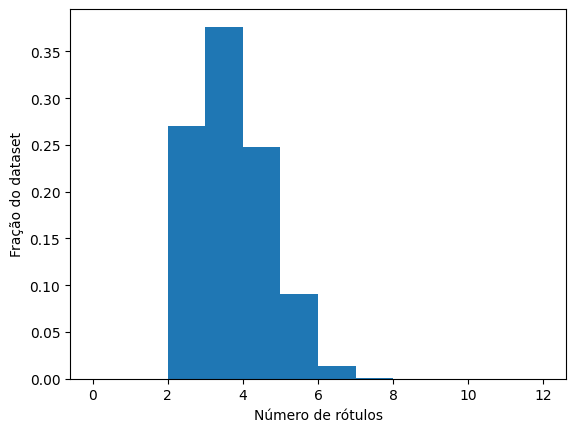

In [56]:
import matplotlib.pyplot as plt

%matplotlib inline

def plotar_distribuicao_rotulos(label_matrix: np.ndarray) -> None:
    """
    Plotar a distribuição dos números de rótulos por exemplo no dataset.
    """

    num_labels_per_example = (label_matrix != ABSTENCAO).sum(axis=1)

    plt.hist(num_labels_per_example, density=True, bins=range(label_matrix.shape[1]))

    plt.xlabel("Número de rótulos")
    plt.ylabel("Fração do dataset")

    plt.show()

plotar_distribuicao_rotulos(L_treinamento)

# Passo 2 - Implementando o Modelo de Rotulagem

Agora é o próximo passo da pipeline de dados. Fizemos a execução das nossas LFs. Temos uma cobertura de 100% dos nossos dados.

Agora vamos contruir o nosso Modelo de Rotulagem que será capaz de rotular um rview como positivo ou negativo.

In [57]:
from snorkel.labeling.model import MajorityLabelVoter

modelo_maioria_votos = MajorityLabelVoter()
preds_train = modelo_maioria_votos.predict(L=L_treinamento)

In [58]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_treinamento, n_epochs=500, log_freq=100, seed=314)

100%|██████████| 500/500 [00:01<00:00, 285.10epoch/s]


In [59]:
majority_pred = modelo_maioria_votos.predict(L=L_dev)
label_model_pred = label_model.predict(L=L_dev)

print(f'Relatório de Classificação por maioria dos votos: \n{classification_report(df_dev.sentimento.values, majority_pred)}')
print(f'Número of abstenções: {np.count_nonzero(majority_pred == -1)}')
print(f'\n\nRelatório de Classificação por label model: \n{classification_report(df_dev.sentimento.values, label_model_pred)}')
print(f'Número de abstenções: {np.count_nonzero(label_model_pred == -1)}')


Relatório de Classificação por maioria dos votos: 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.63      0.78      0.70       203
           1       0.81      0.41      0.55       197

    accuracy                           0.60       400
   macro avg       0.48      0.40      0.42       400
weighted avg       0.72      0.60      0.62       400

Número of abstenções: 49


Relatório de Classificação por label model: 
              precision    recall  f1-score   support

           0       0.51      0.54      0.53       203
           1       0.50      0.47      0.49       197

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.51      0.51      0.51       400

Número de abstenções: 0


Será importante entender o peso de cada função de rotulagem. Assim podemos ver a contribuição que cada uma deu para o resultado final do nosso modelo de rotulagem.

Também podemos identificar aquelas que contribuíram mais ou menos.

In [63]:
for nome, valor in zip([lf.name for lf in lfs], label_model.get_weights()):
    print(f'{nome}: {valor*100:.2f}%')

lf_regex_a: 92.06%
lf_regex_b: 73.68%
lf_regex_c: 50.92%
lf_regex_d: 56.46%
lf_regex_e: 52.58%
lf_regex_f: 49.95%
lf_regex_g: 43.42%
lf_regex_h: 50.72%
lf_regex_i: 47.83%
lf_regex_j: 45.44%
lf_regex_k: 100.00%
lf_hf_sentiment: 59.42%
lf_ssl: 51.75%


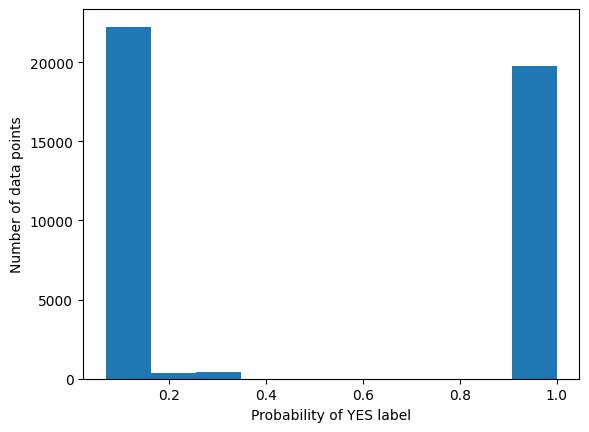

In [64]:
from typing import List

def plot_probability_distribution(probabilities: List[float]) -> None:
    """
    Plotando um histograma de probabilidades.
    """
    plt.hist(probabilities, bins=10)
    plt.xlabel("Probability of YES label")
    plt.ylabel("Number of data points")
    plt.show()

probs_train = label_model.predict_proba(L=L_treinamento)
plot_probability_distribution(probs_train[:, POSITIVO])

In [66]:
df_dev['sentimento'].value_counts(normalize=True)

sentimento
0    0.5075
1    0.4925
Name: proportion, dtype: float64

In [67]:
probs_train

array([[5.56219191e-07, 9.99999444e-01],
       [3.19126120e-02, 9.68087388e-01],
       [8.90317088e-01, 1.09682912e-01],
       ...,
       [8.90317088e-01, 1.09682912e-01],
       [5.56219191e-07, 9.99999444e-01],
       [8.90317088e-01, 1.09682912e-01]])

In [68]:
from snorkel.labeling import filter_unlabeled_dataframe

df_treinamento_fracamente_rotulado, probs_treinamento_fracamente_rotulado = filter_unlabeled_dataframe(
    X=df_treinamento, y=probs_train, L=L_treinamento
)

In [69]:
if len(df_treinamento_fracamente_rotulado) == len(df_treinamento):
    print("Todos os pontos foram rotulados fracamente!")
else:
    print(f"Número de textos depois da filtragem: {len(df_treinamento_fracamente_rotulado)} (removidos {len(df_treinamento) - len(df_treinamento_fracamente_rotulado)} textos)")

Todos os pontos foram rotulados fracamente!


# Passo 3 - Treinando o modelo final para rotulagem

In [70]:
vetorizador = TfidfVectorizer(ngram_range=(1,2), strip_accents='unicode', lowercase=True, max_features=3000, max_df=0.85, min_df=3)
vetorizador.fit(df_treinamento.texto.values)
X_treinamento = vetorizador.transform(df_treinamento.texto.values).toarray()
X_dev = vetorizador.transform(df_dev.texto.values).toarray()

y_dev_true = df_dev.sentimento.values

Como nosso modelo possui a probabilidade de cada classe relacionada ao sentimento. Assim sendo, podemos ver as probabilidades a seguir que foram calculadas anteriormente.

In [71]:
probs_train

array([[5.56219191e-07, 9.99999444e-01],
       [3.19126120e-02, 9.68087388e-01],
       [8.90317088e-01, 1.09682912e-01],
       ...,
       [8.90317088e-01, 1.09682912e-01],
       [5.56219191e-07, 9.99999444e-01],
       [8.90317088e-01, 1.09682912e-01]])

In [72]:
y_train_prob_labels = probs_train
y_train_prob_labels[:5]

array([[5.56219191e-07, 9.99999444e-01],
       [3.19126120e-02, 9.68087388e-01],
       [8.90317088e-01, 1.09682912e-01],
       [8.69995090e-01, 1.30004910e-01],
       [8.90317088e-01, 1.09682912e-01]])

In [73]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
import tensorflow as tf

def build_neural_network(input_dimension: int, hidden_layer1_size: int, hidden_layer2_size: int,
                         hidden_layer3_size: int, output_size: int, dropout_rate: float, learning_rate: float) -> Model:
    """
    Construindo uma rede neural com 3 camadas escondidas.
    """

    entrada = Input(shape=(input_dimension,))

    camada_escondida_1 = Dense(hidden_layer1_size)(entrada)
    camada_saida_1 = Dropout(dropout_rate)(camada_escondida_1)

    camada_escondida_2 = Dense(hidden_layer2_size, activation='relu')(camada_saida_1)
    camada_saida_2 = Dropout(dropout_rate)(camada_escondida_2)

    camada_escondida_3 = Dense(hidden_layer3_size, activation='relu')(camada_saida_2)
    camada_saida_3 = Dropout(dropout_rate)(camada_escondida_3)

    saida = Dense(output_size, activation='softmax')(camada_saida_3)

    modelo = Model(inputs=entrada, outputs=saida)
    modelo.compile(optimizers.Adam(learning_rate), 'kullback_leibler_divergence', ['accuracy'])

    return modelo

In [75]:
import os
import tensorflow as tf
from typing import Tuple
from numpy import ndarray

def treinamento_rede_neural_keras(X_train: ndarray, y_train: ndarray, X_dev: ndarray, y_dev: ndarray) -> tf.keras.Model:

    input_dimension = X_train.shape[1]
    hidden_layer1_size = 384
    hidden_layer2_size = 192
    hidden_layer3_size = 96
    output_size = y_train.shape[1]

    dropout_rate = 0.1
    learning_rate = 0.0003
    num_epochs = 20
    batch_size = 256

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

    with tf.device('/cpu:0'):
        modelo = build_neural_network(input_dimension, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, output_size, dropout_rate, learning_rate)

        modelo.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_dev, y_dev), callbacks=[early_stopping_callback, model_checkpoint_callback])

    modelo.load_weights('best_model.h5')

    os.remove('best_model.h5')

    return modelo

In [76]:
def print_metricas(true_labels: ndarray, predicted_labels: ndarray) -> None:
    if len(true_labels.shape) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    if len(predicted_labels.shape) > 1:
        predicted_labels = np.argmax(predicted_labels, axis=1)

    print(f'Relatório de Classificação do modelo de DL: \n{classification_report(true_labels, predicted_labels)}')
    print(f'MCC: {matthews_corrcoef(true_labels, predicted_labels)}')
    print(f'ACC: {accuracy_score(true_labels, predicted_labels)}')
    print(f'Matriz de Confusão: \n{confusion_matrix(true_labels, predicted_labels)}')

In [78]:
model_tf = treinamento_rede_neural_keras(X_treinamento, y_train_prob_labels, X_dev, np.eye(2)[y_dev_true])

Epoch 1/20
168/168 [==============================] - 9s 38ms/step - loss: 0.3204 - accuracy: 0.7385 - val_loss: 1.2424 - val_accuracy: 0.5125
Epoch 2/20
168/168 [==============================] - 6s 39ms/step - loss: 0.1033 - accuracy: 0.9416 - val_loss: 1.7099 - val_accuracy: 0.5025
Epoch 3/20
168/168 [==============================] - 4s 22ms/step - loss: 0.0677 - accuracy: 0.9648 - val_loss: 2.0215 - val_accuracy: 0.5050
Epoch 4/20
168/168 [==============================] - 4s 24ms/step - loss: 0.0567 - accuracy: 0.9696 - val_loss: 2.2472 - val_accuracy: 0.5125
Epoch 5/20
168/168 [==============================] - 5s 30ms/step - loss: 0.0520 - accuracy: 0.9714 - val_loss: 2.3690 - val_accuracy: 0.5050
Epoch 6/20
168/168 [==============================] - 4s 22ms/step - loss: 0.0487 - accuracy: 0.9730 - val_loss: 2.3984 - val_accuracy: 0.5100


Conforme podemos observar, com 6 épocas, conseguimos atingir um valor máximo de acurácia.

In [79]:
y_dev_pred = model_tf.predict(X_dev)
y_dev_pred[:5]

13/13 [==============================] - 1s 6ms/step


array([[0.92287844, 0.07712159],
       [0.8761351 , 0.1238649 ],
       [0.8394409 , 0.16055912],
       [0.6184873 , 0.3815127 ],
       [0.9272169 , 0.07278311]], dtype=float32)

In [80]:
print_metricas(y_dev_true, y_dev_pred)

Relatório de Classificação do modelo de DL: 
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       203
           1       0.51      0.46      0.48       197

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.51      0.51      0.51       400

MCC: 0.023495205927156086
ACC: 0.5125
Matriz de Confusão: 
[[115  88]
 [107  90]]


Vamos checar alguns erros que foram cometidos.

In [81]:
idxs = np.where(np.argmax(y_dev_pred, axis=1) != df_dev.sentimento.values)[0]

for idx in idxs:
    print(f'Previsto: {np.argmax(y_dev_pred, axis=1)[idx]}, Sentimento verdadeiro: {df_dev.sentimento.values[idx]}')
    print(df_dev.texto.values[idx])
    print('')

Previsto: 0, Sentimento verdadeiro: 1
"the kennel murder case" comeca em uma corrida e nao para ate o final. todos tinham motivos para matar a vitima e varias pessoas tentaram. william powell e fantastico como philo vance, detetive cavalheiro. mary astor e refrescante como a sobrinha que so quer se casar com seu cavalheiro escoces e desfrutar de sua heranca. este filme vem emparelhado com "nancy drew, reporter" em dvd, que tambem e divertido. se voce tiver que alugar o disco ou retira-lo da sua biblioteca local, faca-o. seu puro entretenimento!

Previsto: 0, Sentimento verdadeiro: 1
victor nunez impregna esse relato nao sentimental da jornada emocional de uma jovem mulher com um senso de poesia raramente visto no cinema. por poesia quero dizer o sentido em que o literario e o cinematico entram em jogo. ha algo de muito literario no filme, quase como se um romance tivesse sido adaptado pagina por pagina em tela. nesse sentido, o filme atinge profundidades que muitos nao conseguem; mas t

Conforme é possível ver, algumas reviews que foram erradas, estão bem estranhas que até ao ler é difícil definir se é positivo ou negativo.

Sendo assim, podemos observar que é é normal ter errado em alguns casos, principalmente devido a existência de alguns termos que podem ter feito que o erro fosse realizado.

# Conclusões

Com esse modelo treinado, podemos usá-lo para fazer a predições e concluímos a pipeline de supervisão fraca.